In [1]:
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.linalg import block_diag
import pickle
import matplotlib as mpl

import matplotlib.pyplot as plt
from timeit import default_timer
import torch
from functools import partial




from Solver import *


import sys
sys.path.append('../Utility')
import PlotDefault
import NeuralNet
import KalmanInversion 
from Numerics import interpolate_f2c, gradient_first_f2c

# Reference quadratic function
 $$D(\theta) = \sqrt{\theta^2 + (\frac{\partial \theta}{\partial x})^2}$$

# Load network from indirect training

In [5]:
TRAINING_TYPE = "direct" # indirect   indirect_res

if TRAINING_TYPE == "direct":
    trained_net = torch.load("direct.nn")
else:
    (save_folder, uki_iter) = ("indirect_NN" , 1) if TRAINING_TYPE=="direct" else ("indirect_NN_res" , 1)
 
    uki_obj = pickle.load( open( save_folder + "/ukiobj-" + str(N_iter-1) + ".dat", "rb" ) )
    trained_net = NeuralNet.create_net(ind, outd, layers, width, activation, initializer, outputlayer, uki_obj.theta_mean[-1])




print(trained_net.modus['LinM{}'.format(1)].weight)
print(trained_net.modus['LinM{}'.format(1)].bias)
print(trained_net.modus['LinMout'].weight)
print(trained_net.modus['LinMout'].bias)

Parameter containing:
tensor([[  2.3902,  -7.1230],
        [ -7.9712,   3.4467],
        [ -9.7669,  -2.5973],
        [ 42.2600, -46.5892],
        [180.3425,   2.8901],
        [  0.9141,  -3.8117],
        [  0.8900,  -2.8390],
        [ 22.7955, -32.0724],
        [ -0.6733,  -1.5597],
        [  6.1405, -35.1211]], requires_grad=True)
Parameter containing:
tensor([-2.2630, -2.7622, -0.4339, -0.6565,  2.5678, -4.4574, -3.2643, -0.6219,
         0.6834, -0.3774], requires_grad=True)
Parameter containing:
tensor([[ 0.4737,  0.1331,  0.2390,  1.0503, -0.2494, -2.0786,  4.4890, -1.8735,
         -2.8037,  0.8626]], requires_grad=True)
Parameter containing:
tensor([1.9694], requires_grad=True)


# Direct test

/tmp/ipykernel_99016/4279319345.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0=ax[0].pcolormesh(X_test_2d, Y_test_2d, y_test_2d, vmin=vmin, vmax=vmax)
/tmp/ipykernel_99016/4279319345.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1=ax[1].pcolormesh(X_test_2d, Y_test_2d, y_pred_2d, vmin=vmin, vmax=vmax)
/tmp/ipykernel_99016/4279319345.py:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated

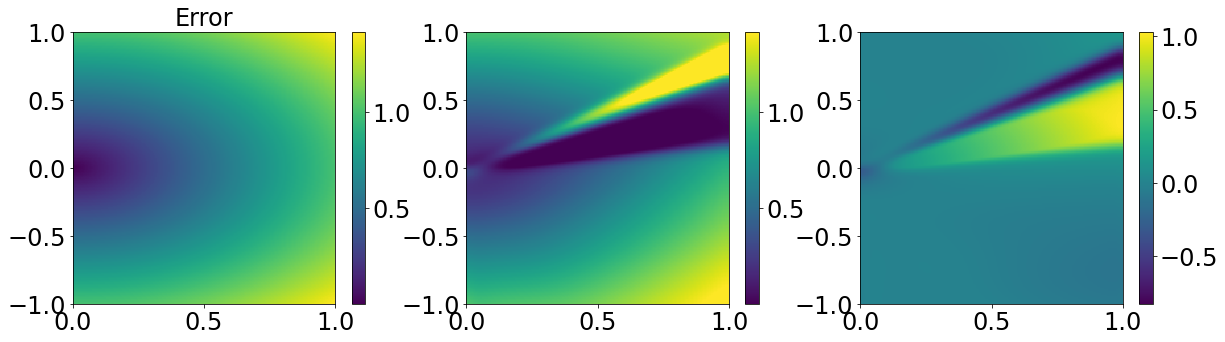

In [9]:
N_test_1d = 200
L_test_1d = 1.0
N_test = N_test_1d**2

x1_test_1d = np.linspace(0, L_test_1d, N_test_1d)
x2_test_1d = np.linspace(-L_test_1d, L_test_1d, N_test_1d)
X_test_2d, Y_test_2d = np.meshgrid(x1_test_1d, x2_test_1d)

x_test = np.vstack((X_test_2d.reshape(-1), Y_test_2d.reshape(-1))).T    
y_test = permeability_ref(x_test).reshape((N_test, 1))


y_pred = NeuralNet.net_eval(net=trained_net, x=x_test, mu_scale=mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma, n_data=N_test_1d)  

y_test_2d = y_test.reshape((N_test_1d,N_test_1d))
y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))


fig, ax = plt.subplots(ncols=3, nrows=1, figsize=((20,5)))


vmin, vmax = y_test_2d.min(), y_test_2d.max()
im0=ax[0].pcolormesh(X_test_2d, Y_test_2d, y_test_2d, vmin=vmin, vmax=vmax)
fig.colorbar(im0, ax=ax[0])
ax[0].set_title("Reference")

im1=ax[1].pcolormesh(X_test_2d, Y_test_2d, y_pred_2d, vmin=vmin, vmax=vmax)
fig.colorbar(im1, ax=ax[1])
ax[0].set_title("Prediction")

im2=ax[2].pcolormesh(X_test_2d, Y_test_2d, y_test_2d - y_pred_2d)
fig.colorbar(im2, ax=ax[2])
ax[0].set_title("Error")

fig.savefig("Poisson-Training-" + TRAINING_TYPE + "Direct-Test.png")



# Plug-in test

100000 max q 0.27057425383730593
200000 max q 0.2714425871030778
100000 max q 0.2705483964388767
200000 max q 0.2714103247483753


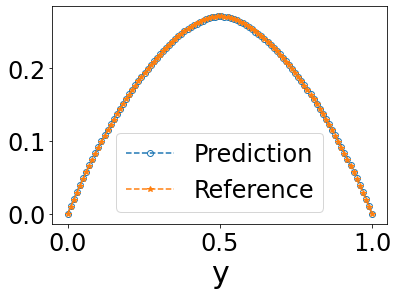

In [7]:
def permeability_nn(q, dq):
    
    x = np.vstack((q, dq)).T
    
    permeability = nn_model(x, trained_net)  
    
    return permeability


L = 1.0
Nx = 100
xx_test = np.linspace(0.0, L, Nx)
f_test = 6*(1-2*xx_test)**2 - 2*(xx_test - xx_test**2)*(1 - 2*xx_test)**2 + 2*(xx_test - xx_test**2)**2 + 2 


f_test /= 2.0
dbc = np.array([0.0, 0.0]) 

MODEL = "exp_nummodel"

if MODEL == "exp_nummodel":
    
    model = lambda q, xx, res : nummodel(permeability_ref, q, xx, res)
    _, t_data_ref, q_data_ref = explicit_solve(model, f_test, dbc, dt = 5.0e-6, Nt = 200000, save_every = 100000, L = L)
    
    nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale=mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma)
    model = lambda q, xx, res : nummodel(nn_model, q, xx, res)
    _, t_data, q_data = explicit_solve(model, f_test, dbc, dt = 5.0e-6, Nt = 200000, save_every = 100000, L = L)

else:
    print("ERROR")


plt.figure()
plt.plot(xx_test, q_data[-1, :],  "--o", fillstyle="none", label="Prediction")
plt.plot(xx_test, q_data_ref[-1, :],  "--*", label="Reference")

plt.xlabel("y")
plt.legend()

plt.savefig("Poisson-Training-" + TRAINING_TYPE + "Indirect-Test.png")